In [145]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon
from typing import Mapping

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from bbtoolkit.structures.attractors import LoopAttractor
from bbtoolkit.structures.attractors.kernels import ricker_kernel_2d
from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


def random_like(array: np.ndarray) -> np.ndarray:
    return np.random.rand(*array.shape)


In [146]:
class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()

In [147]:
class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

In [148]:
from bbtoolkit.environment import Environment
from bbtoolkit.models.bb.neural_generators import TCGenerator
from bbtoolkit.utils.datautils.configparser import EvalConfigParser


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
env = Environment.load('../data/envs/inserted_wall_environment.pkl')
# env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

In [149]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup
from bbtoolkit.structures.tensorgroups import DirectedTensor, DirectedTensorGroup


n, m = 100, 100

weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
n_hd_neurons = len(weights.hd.to.hd)

activity = TensorGroup(
    NamedTensor('ring1', np.zeros((n, m))),
    NamedTensor('ring2', np.zeros((n, m))),
)

connectivity = DirectedTensorGroup()

connectivity.add_tensor(
    DirectedTensor(
        from_='ring1',
        to='ring1',
        weights=dict(inhibitory_phi=.4, tau=.02, beta=.1, alpha=30)
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='ring2',
        to='ring2',
        weights=dict(inhibitory_phi=.4, tau=.02, beta=.1, alpha=30)
    )
)


connectivity.add_tensor(
    DirectedTensor(
        from_='ring2',
        to='ring1',
        weights=dict(phi=5)
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='ring1',
        to='ring2',
        weights=dict(phi=-3)
    )
)

weights = weights.operation_with(
    connectivity,
    lambda a, b: a - b.get('inhibitory_phi', 0),
    on_missing_weights='ignore',
    on_missing_sources='ignore'
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('ring1', np.zeros((n, m))),
    NamedTensor('ring2', np.zeros((n, m))),
)

In [150]:
# dt = 0.005

# m = 100
# n = 100

# attr = LoopAttractor((
#     ricker_kernel_2d(
#         n, m, 2
#     ),
#     ricker_kernel_2d(
#         n, m, 4
#     )
# ), precompute=True)

# r1, r2 = np.random.random(attr.kernel[0].shape), np.random.random(attr.kernel[0].shape)

# w1, w2 = attr(r1, r2).values()

# bkg_drive_ring1 = 2*np.random.rand(*rates.ring1.shape)
# bkg_drive_ring2   = 4*(10+2*np.random.rand(*rates.ring2.shape))


# k_ratio.ring1 = (
#     - activity.ring1
#     + connectivity.ring1.to.ring2['phi']*w1
#     + bkg_drive_ring1
# )

# k_ratio.ring2 = (
#     - activity.ring2
#     + connectivity.ring2.to.ring1['phi']*w2
#     + bkg_drive_ring2
# )

# activity.ring1 += dt/connectivity.ring1.to.ring1['tau']*k_ratio.ring1
# activity.ring2 += dt/connectivity.ring2.to.ring2['tau']*k_ratio.ring2

# rates.ring1 = 1/(1 + np.exp(-2*connectivity.ring1.to.ring1['beta']*(activity.ring1 - connectivity.ring1.to.ring1['alpha'])))
# rates.ring2 = 1/(1 + np.exp(-2*connectivity.ring2.to.ring2['beta']*(activity.ring2 - connectivity.ring2.to.ring2['alpha'])))

In [200]:

from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d
from bbtoolkit.utils.math import circular_gaussian


class AttrCallback(BaseCallback):
    def __init__(
        self,
        attractor
    ):
        super().__init__()

        self.attractor = attractor
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
        ]
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        w1, w2 = self.attractor(self.rates.ring1, self.rates.ring2).values()

        bkg_drive_ring1 = 2*np.random.rand(*self.rates.ring1.shape)
        bkg_drive_ring2   = 4*(10+2*np.random.rand(*self.rates.ring2.shape))

        cue = np.zeros(self.rates.ring2.shape)
        # cue[45:55, ] = 1
        # cue[:10, :] = 1
        # cue[:, :10] = 1
        # draw_line(cue , 90, 5, length=99)
        # draw_line(cue , 45, 5, length=135)
        # draw_line(cue , -45, 5, length=135)
        if self.dynamics_params.step <= 500:
            cue[:5, :] = 1
            cue[:, -5:] = 1
            cue = ((cue - cue.mean())/cue.std())*bkg_drive_ring1.std() + bkg_drive_ring1.mean()


        self.k_ratio.ring1 = (
            - self.activity.ring1
            + self.connectivity.ring1.to.ring2['phi']*w1
            + bkg_drive_ring1 + cue
        )

        self.k_ratio.ring2 = (
            - self.activity.ring2
            + self.connectivity.ring2.to.ring1['phi']*w2
            + bkg_drive_ring2
        )

        self.activity.ring1 += self.dt/self.connectivity.ring1.to.ring1['tau']*self.k_ratio.ring1
        self.activity.ring2 += self.dt/self.connectivity.ring2.to.ring2['tau']*self.k_ratio.ring2

        self.rates.ring1 = 1/(1 + np.exp(-2*self.connectivity.ring1.to.ring1['beta']*(self.activity.ring1 - self.connectivity.ring1.to.ring1['alpha'])))
        self.rates.ring2 = 1/(1 + np.exp(-2*self.connectivity.ring2.to.ring2['beta']*(self.activity.ring2 - self.connectivity.ring2.to.ring2['alpha'])))


In [152]:
class AttrPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[:6, 2:7])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[:6, 7:])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'fig',
            'rates',
            'weights',
            'activity',
            'k_ratio',
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        self.hd_ax_1.imshow(
            self.rates.ring1,
            origin='lower',
            cmap='coolwarm'
        )
        self.hd_ax_2.imshow(
            self.rates.ring2,
            origin='lower',
            cmap='coolwarm'
        )

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_2.clear()

In [156]:
import math
import numpy as np

def draw_line(m, phi, w, length=100):
    # Convert angle to radians
    phi_radians = np.radians(phi)
    
    # Calculate the end point of the line
    x_end = int(length * np.cos(phi_radians))
    y_end = int(length * np.sin(phi_radians))
    
    # Calculate line points (basic Bresenham's algorithm or similar could be used here)
    x, y = np.linspace(0, x_end, length), np.linspace(0, y_end, length)
    
    # Calculate width offsets
    for offset in np.linspace(-w/2, w/2, w):
        # Calculate perpendicular offsets for width
        perp_x = offset * np.sin(phi_radians)
        perp_y = -offset * np.cos(phi_radians)
        
        # Apply offsets to x and y coordinates
        xi = np.round(x + perp_x).astype(int)
        yi = np.round(y + perp_y).astype(int)
        
        # Draw the line with width on the matrix
        m[xi, yi] = 1

# Note: This is a simplified example. You may need to adjust it based on your matrix size and desired line properties.

2024-06-13 16:12:32 - DEBUG - Loaded backend inline version unknown.


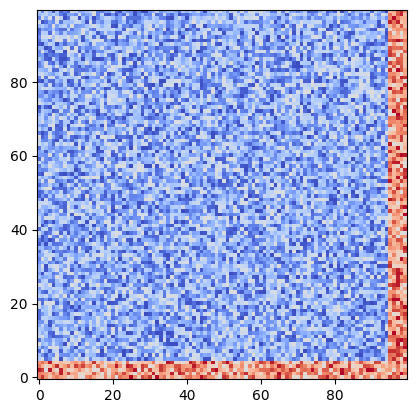

In [194]:
# m = np.zeros(rates.ring2.shape)
# m[:10, :] = 1
# m[:, :10] = 1
# m = rates


m = np.zeros((100, 100))
# draw_line(m , 45, 5, length=135)
m[:5, :] = 1
m[:, -5:] = 1

# draw_line(m , -45, 5, length=135)

drive = (4*(10 + 2*np.random.rand(*rates.ring2.shape)))

m = ((m - m.mean())/m.std())*drive.std() + drive.mean()

%matplotlib inline
plt.imshow(m + drive, origin='lower', cmap='coolwarm')

2024-06-13 17:20:47 - DEBUG - Loaded backend inline version unknown.


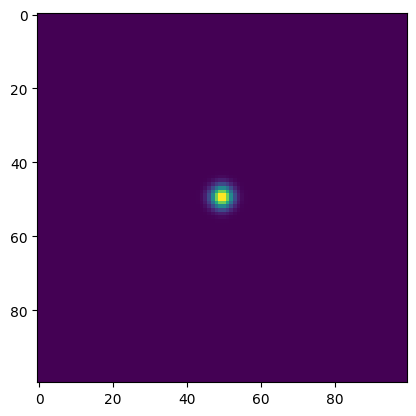

In [205]:
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_2d
%matplotlib inline
plt.imshow(gaussian_kernel_2d(
    100, 100, 2
))
raise

In [201]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters
from bbtoolkit.structures.attractors import LoopAttractor
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d, gaussian_kernel_2d

%matplotlib qt

dt = .002
n, m  = 100, 100
direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=np.pi/2)
cache['weights'] = weights.copy()
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
cache.connectivity.ring1.to.ring2['phi'] = -3
cache.connectivity.ring2.to.ring1['phi'] = 5


dynamics = DynamicsManager(
    dt,
    callbacks=[
        AttrCallback(
            LoopAttractor((
                ricker_kernel_2d(
                    n, m, 2
                ),
                ricker_kernel_2d(
                    n, m, 4
                )
            ), precompute=True)
        ),
        TimerCallback(),
        PlottingCallback(
            [
                TimerPlotter((0, 0)),
                AttrPlotter()
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        ),
        FramesStoringCallback(5, '../tmp')
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

2024-06-13 16:18:01 - DEBUG - Loaded backend qtagg version 6.7.0.


out:  (None, None, None, None)
out:  (None, None, None, None)


KeyboardInterrupt: 

In [116]:
from bbtoolkit.utils.datautils import remove_files_from_dir


remove_files_from_dir('../tmp')

2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_5.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_10.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_15.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_20.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_25.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_30.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_35.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_40.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_45.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_50.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_55.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_60.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_65.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_70.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_75.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_80.png
2024-06-13 15:46:40 - INFO - Removed: ../tmp/frame_85.png
2024-06-13 15:4

2024-06-13 15:19:57 - DEBUG - Loaded backend inline version unknown.


2024-06-13 15:19:57 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7c4a98f52d80>


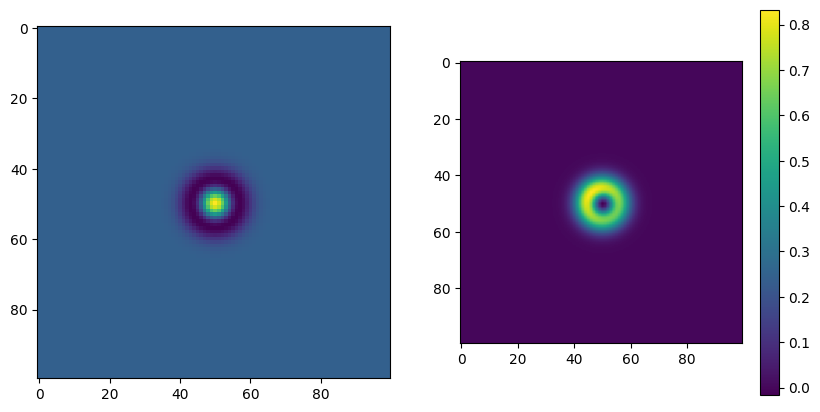

In [79]:
%matplotlib inline

from bbtoolkit.structures.attractors.kernels import gaussian_kernel_2d


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(
    ricker_kernel_2d(
        n, m, 4
    )
)
a = ax2.imshow(
    - ricker_kernel_2d(
        n, m, 4
    ) + gaussian_kernel_2d(
        n, m, 4
    )
)
plt.colorbar(a)

2024-06-13 14:16:09 - DEBUG - Loaded backend inline version unknown.


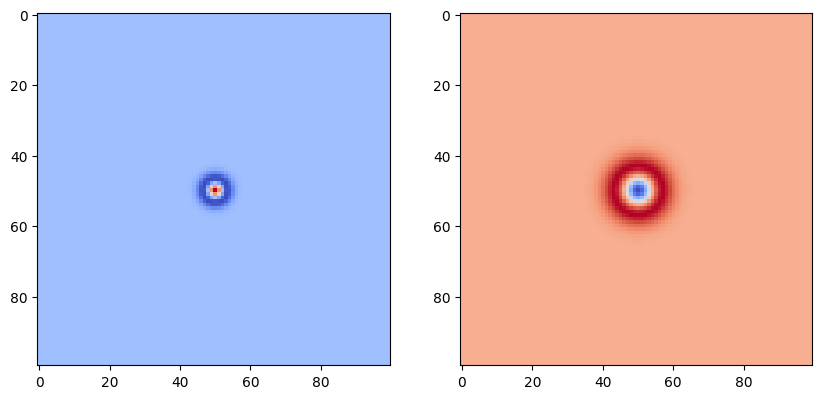

In [26]:
%matplotlib inline
ker1, ker2 = dynamics.callbacks[0].attractor.kernel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(ker1, cmap='coolwarm')
ax2.imshow((1-ker2), cmap='coolwarm')